In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english')) 
stemmer = SnowballStemmer("english") 

from tqdm import tqdm
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

from keras.layers import Embedding
from keras import layers
from keras import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score,roc_auc_score,average_precision_score,precision_recall_curve,PrecisionRecallDisplay,roc_curve,RocCurveDisplay

In [1]:
# Load original data 
import pandas as pd
train_data = pd.read_csv("../input/uoe-project-amazon/quora_train.csv") 
print(train_data.shape)  
train_data.head(5)
test_data = pd.read_csv("../input/uoe-project-amazon/quora_test.csv")  
print(test_data.shape)  
test_data.head(5)

(323480, 7)
(80871, 7)


,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate
0,384611,384611,752053,752054,What are the pros and cons of Legalzoom-genera...,Where can I read reviews of LegalZoom?,0
1,258398,258398,508576,508577,Why does ready-to-eat poha absorb water instan...,Ultimate teen patti hacker?,0
2,234932,234932,462847,462848,How apps like paytm earn profit when they are ...,How does Paytm earn by giving extra cash back ...,1
3,347622,347622,681123,681124,What daily habits can greatly upgrade life?,What are your daily habits that improve your p...,1
4,388186,388186,758881,758882,What video game world would you want to live in?,"If you could live in any video game setting, w...",1


In [ ]:
#check whether data exists missing value and to see the proportion of missing value
train_data.isnull().any() 
print(train_data.isnull().sum())
(train_data.shape[0] - train_data.count())/train_data.shape[0]

In [2]:
# filling in the blank of nan rows
train_data['question1'].fillna('',inplace=True)
train_data['question2'].fillna('',inplace=True)
test_data.fillna('',inplace=True)

In [ ]:
# double check missing value
train_data.isnull().any() 
test_data.isnull().any() 

In [3]:
# drop question ID and pairing ID
train_data = train_data.drop(train_data.columns[[0,1,2,3]], axis=1)
test_data = test_data.drop(test_data.columns[[0,1,2,3]], axis=1)

# Initial data analysis

In [ ]:
color = sns.color_palette()
train_duplicate = train_data['is_duplicate'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(train_duplicate.index, train_duplicate.values, alpha=0.7, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=14)
plt.show()

In [ ]:
train_duplicate / train_duplicate.sum() 

In [ ]:
#to check the number of words in a question
all_question = pd.DataFrame(pd.concat([train_data['question1'], train_data['question2']])) 
all_question.columns = ["questions"]
all_question["total_words"] = all_question["questions"].apply(lambda x : len(str(x).split())) 

In [ ]:
count_words = all_question['total_words'].value_counts() 

plt.figure(figsize=(12,6))
sns.barplot(count_words.index, count_words.values, alpha=0.7, color=color[2])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Number of words in each question', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

# Text pre-processing

In [4]:
def decontracted(phrase):
    '''
    This function replace abbreviation with the complete words. For example, `won't` would be replaced by `will not`.
    '''
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [5]:
def striphtml(data): 
    '''
    This function recompile problematic database objects. For example, Avg antivirus 1800</v\>251<’-‘>4919 Avg tech support phone number 24x7??
    '''
    cleanr = re.compile('<.*?>') 
    cleantext = re.sub(cleanr, ' ', str(data)) 
    return cleantext

In [6]:
def stripunc(data): 
    return re.sub('[^A-Za-z]+', ' ', str(data), flags=re.MULTILINE|re.DOTALL)

In [7]:
def compute(sent): 
    '''
    This function apply the above three functions and turn uppercase to lowercase.
    '''
    sent = decontracted(sent) 
    sent = striphtml(sent) 
    sent = stripunc(sent) 
    words=word_tokenize(str(sent.lower()))   
    
    #Removing all single letter and and stopwords from question 
    sent1=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1)) 
    sent2=' '.join(str(j) for j in words if j not in stop_words and (len(j)!=1)) 
    return sent1, sent2

In [ ]:
clean_stemmed_q1 = []
clean_stemmed_q2 = []
clean_q1 = []
clean_q2 = []
combined_stemmed_text = []
for _, row in tqdm(train_data.iterrows()):
    csq1, cq1 = compute(row['question1'])
    csq2, cq2 = compute(row['question2'])
    clean_stemmed_q1.append(csq1)
    clean_q1.append(cq1)
    clean_stemmed_q2.append(csq2)
    clean_q2.append(cq2)
    combined_stemmed_text.append(csq1+" "+csq2)

23450it [00:25, 909.97it/s] 

In [ ]:
clean_stemmed_q1_t = []
clean_stemmed_q2_t = []
clean_q1_t = []
clean_q2_t = []
combined_stemmed_text_t = []
for _, row in tqdm(test_data.iterrows()):
    
    csq1_t, cq1_t = compute(row['question1'])
    csq2_t, cq2_t = compute(row['question2'])
    clean_stemmed_q1_t.append(csq1_t)
    clean_q1_t.append(cq1_t)
    clean_stemmed_q2_t.append(csq2_t)
    clean_q2_t.append(cq2_t)
    combined_stemmed_text_t.append(csq1_t+" "+csq2_t)

In [ ]:
train_data['clean_stemmed_q1'] = clean_stemmed_q1
train_data['clean_stemmed_q2'] = clean_stemmed_q2
train_data['clean_q1'] = clean_q1
train_data['clean_q2'] = clean_q2
train_data['combined_stemmed_text'] = combined_stemmed_text

In [ ]:
test_data['clean_stemmed_q1_t'] = clean_stemmed_q1_t
test_data['clean_stemmed_q2_t'] = clean_stemmed_q2_t
test_data['clean_q1_t'] = clean_q1_t
test_data['clean_q2_t'] = clean_q2_t
test_data['combined_stemmed_text_t'] = combined_stemmed_text_t

In [ ]:
#check the format of data
train_data.head()
test_data.head()

In [ ]:
#split validation dataset
#clean q1 and q2 datasets
X_train, X_val, y_train, y_val = train_test_split(train_data[['clean_q1', 'clean_q2']],
                                                  train_data['is_duplicate'],
                                                  test_size=0.2, 
                                                  random_state=42) 

In [ ]:
#stemmed q1 and q2 datasets
X_train_stemmed, X_val_stemmed = train_test_split(train_data[['clean_stemmed_q1', 'clean_stemmed_q2']],      
                                                  test_size=0.2, 
                                                  random_state=42) 

In [ ]:
#combine clean_q1 and clean_q2 horizontally
X_train['notstemmed_text'] = X_train[['clean_q1','clean_q2']].apply(lambda x:str(x[0])+" "+str(x[1]), axis=1) 

#combine clean_stemmed_q1 and clean_stemmed_q2 horizontally
X_train_stemmed['stemmed_text'] = X_train_stemmed[['clean_stemmed_q1','clean_stemmed_q2']].apply(lambda x:str(x[0])+" "+str(x[1]), axis=1) 

# Tokenizing the data

In [ ]:
maxlen = 100 
max_words = 10000 

#For not stemmed data(clean_q1 and clean_q2)
tokenizer_notstemmed = Tokenizer(num_words=max_words)
tokenizer_notstemmed.fit_on_texts(X_train['notstemmed_text'].values)  

X_train['clean_q1'] = X_train['clean_q1'].astype(str) 
X_train['clean_q2'] = X_train['clean_q2'].astype(str)
X_val['clean_q1'] = X_val['clean_q1'].astype(str)
X_val['clean_q2'] = X_val['clean_q2'].astype(str)

train_q1_seq = tokenizer_notstemmed.texts_to_sequences(X_train['clean_q1'].values)
train_q2_seq = tokenizer_notstemmed.texts_to_sequences(X_train['clean_q2'].values)
val_q1_seq = tokenizer_notstemmed.texts_to_sequences(X_val['clean_q1'].values)
val_q2_seq = tokenizer_notstemmed.texts_to_sequences(X_val['clean_q2'].values)

train_q1_seq = pad_sequences(train_q1_seq, maxlen=maxlen, padding='post') 
train_q2_seq = pad_sequences(train_q2_seq, maxlen=maxlen, padding='post') 
val_q1_seq = pad_sequences(val_q1_seq, maxlen=maxlen, padding='post') 
val_q2_seq = pad_sequences(val_q2_seq, maxlen=maxlen, padding='post')

word_index_notstemmed = tokenizer_notstemmed.word_index 
print('Found %s unique tokens for not stemmed words.' % len(word_index_notstemmed))

#For stemmed data
tokenizer_stemmed = Tokenizer(num_words=max_words)
tokenizer_stemmed.fit_on_texts(X_train_stemmed['stemmed_text'].values)  


X_train_stemmed['clean_stemmed_q1'] = X_train_stemmed['clean_stemmed_q1'].astype(str) 
X_train_stemmed['clean_stemmed_q2'] = X_train_stemmed['clean_stemmed_q2'].astype(str)
X_val_stemmed['clean_stemmed_q1'] = X_val_stemmed['clean_stemmed_q1'].astype(str)
X_val_stemmed['clean_stemmed_q2'] = X_val_stemmed['clean_stemmed_q2'].astype(str)

train_q1_seq_stemmed = tokenizer_stemmed.texts_to_sequences(X_train_stemmed['clean_stemmed_q1'].values)
train_q2_seq_stemmed = tokenizer_stemmed.texts_to_sequences(X_train_stemmed['clean_stemmed_q2'].values)
val_q1_seq_stemmed = tokenizer_stemmed.texts_to_sequences(X_val_stemmed['clean_stemmed_q1'].values)
val_q2_seq_stemmed = tokenizer_stemmed.texts_to_sequences(X_val_stemmed['clean_stemmed_q2'].values)

train_q1_seq_stemmed = pad_sequences(train_q1_seq_stemmed, maxlen=maxlen, padding='post') 
train_q2_seq_stemmed = pad_sequences(train_q2_seq_stemmed, maxlen=maxlen, padding='post') 
val_q1_seq_stemmed = pad_sequences(val_q1_seq_stemmed, maxlen=maxlen, padding='post') 
val_q2_seq_stemmed = pad_sequences(val_q2_seq_stemmed, maxlen=maxlen, padding='post')

word_index_stemmed = tokenizer_stemmed.word_index 
print('Found %s unique tokens for stemmed words.' % len(word_index_stemmed))

In [ ]:
#same operation to test dataset
test_data['clean_q1_t'] = test_data['clean_q1_t'].astype(str)
test_data['clean_q2_t'] = test_data['clean_q2_t'].astype(str)
#not stemmed data
test_q1_seq = tokenizer_notstemmed.texts_to_sequences(test_data['clean_q1_t'].values)
test_q2_seq = tokenizer_notstemmed.texts_to_sequences(test_data['clean_q2_t'].values)
test_q1_seq_stemmed = tokenizer_stemmed.texts_to_sequences(test_data['clean_stemmed_q1_t'].values)
test_q2_seq_stemmed = tokenizer_stemmed.texts_to_sequences(test_data['clean_stemmed_q2_t'].values)
#stemmed data
test_q1_seq = pad_sequences(test_q1_seq, maxlen=maxlen, padding='post')
test_q2_seq = pad_sequences(test_q2_seq, maxlen=maxlen, padding='post')
test_q1_seq_stemmed = pad_sequences(test_q1_seq_stemmed, maxlen=maxlen, padding='post')
test_q2_seq_stemmed = pad_sequences(test_q2_seq_stemmed, maxlen=maxlen, padding='post')

labels_test = np.asarray(test_data['is_duplicate'].to_list())
print('Shape of test tensor:', labels_test.shape)

In [ ]:
#train and validation dataset for not stemmed q1 and q2 
train_q1_seq
val_q1_seq
train_q2_seq
val_q2_seq
#train and validation dataset for stemmed q1 and q2
train_q1_seq_stemmed
val_q1_seq_stemmed
train_q2_seq_stemmed
val_q2_seq_stemmed
#test dataset for not stemmed q1 and q2
test_q1_seq
test_q1_seq
#test dataset for stemmed q1 and q2
test_q1_seq_stemmed
test_q2_seq_stemmed

# word2vec embedding

In [ ]:
#load in word2vec
word_vectors = KeyedVectors.load_word2vec_format('../input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin', binary=True)
embedding_dim=300 
vocabulary_size=min(len(word_index_stemmed)+1,max_words) 
 
embedding_matrix_stemmed = np.zeros((vocabulary_size, embedding_dim))  

for word, i in word_index_stemmed.items(): 
    if i>=max_words:  
        continue  
    try:
        embedding_vector = word_vectors[word]  
        embedding_matrix_stemmed[i] = embedding_vector
    except KeyError:
        embedding_matrix_stemmed[i]=np.random.normal(0,np.sqrt(0.25),embedding_dim) #？

embedding_matrix_notstemmed = np.zeros((vocabulary_size, embedding_dim)) 
for word, i in word_index_notstemmed.items(): 
    if i>=max_words:  
        continue  
    try:
        embedding_vector = word_vectors[word] 
        embedding_matrix_notstemmed[i] = embedding_vector
    except KeyError:
        embedding_matrix_notstemmed[i]=np.random.normal(0,np.sqrt(0.25),embedding_dim)
        
del(word_vectors)

In [ ]:
#check the embedding matrix
embedding_matrix_stemmed.shape 
embedding_matrix_notstemmed.shape 

In [ ]:
class customMetrics(tf.keras.callbacks.Callback):
    '''
    This is a custom metric which is accessible using the keras Callback function. 
    This metric saves and prints the F1 score, precision and recall of the validation data after each epoch.
    The metrics are calculated using functions from `scikit-learn`.
    '''
    def __init__(self, validation):   
        super(customMetrics, self).__init__()
        self.validation = validation 
        
    def on_train_begin(self, logs={}):        
        self.f1_scores = []
        self.precisions = []
        self.recalls = []
        self.auc = []
        
    def on_epoch_end(self, epoch, logs={}):
        true_lebels = self.validation[1]   
        predictions = (np.asarray(self.model.predict(self.validation[0]))).round()        
    
        f1_score_epoch = f1_score(true_lebels, predictions)
        precision_epoch = precision_score(true_lebels, predictions)
        recall_epoch = recall_score(true_lebels, predictions)                 
        auc_epoch = roc_auc_score(true_lebels, predictions)
        
        self.f1_scores.append(f1_score_epoch)
        self.precisions.append(precision_epoch)
        self.recalls.append(recall_epoch)
        self.auc.append(auc_epoch)
        
        print('For this epoch:\n','F1 score:', f1_score_epoch, '---Precision:', precision_epoch, '---Recall:', recall_epoch,'---Auc:',auc_epoch)

In [ ]:
def loss_plot(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model 1: word2vec embedding+logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
y_training=y_train
y_training.to_list()

#prepare combined stemmed text for logistic model 
train_seq_stemmed = tokenizer_stemmed.texts_to_sequences(X_train_stemmed['stemmed_text'].values)
train_seq_stemmed = pad_sequences(train_seq_stemmed, maxlen=maxlen, padding='post')
test_seq_stemmed = tokenizer_stemmed.texts_to_sequences(test_data['combined_stemmed_text_t'].values)
test_seq_stemmed = pad_sequences(test_seq_stemmed, maxlen=maxlen, padding='post')

#train:x,y
len(y_training)
len(train_seq_stemmed)
#test:x,y
len(test_seq_stemmed)
len(labels_test)

#fitting logistic model
lr = LogisticRegression(random_state=0)
lr.fit(train_seq_stemmed, y_training)
y_pred=lr.predict(test_seq_stemmed)
score = lr.score(train_seq_stemmed, y_training)
print(" mean accuracy on the given test data and labels:",score) 

In [ ]:
#using test data to measure the performance of the model
model1_f1 = f1_score(labels_test, y_pred)
model1_precision = precision_score(labels_test, y_pred)    
model1_recall = recall_score(labels_test, y_pred) 
model1_auc = roc_auc_score(labels_test, y_pred)
print('Test F1 score for Model 1:', model1_f1, '\nTest precision for Model 1:', model1_precision, 
      '\nTest recall for Model 1:', model1_recall,'\nTest auc for Model 1:', model1_auc)

In [ ]:
#roc curve
fpr, tpr, _ = roc_curve(labels_test, y_pred, pos_label=None) 
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
confusion_matrix=confusion_matrix(labels_test,y_pred)
print("confusion matrix is:\n",confusion_matrix)

In [ ]:
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=labels_test, y_pred=y_pred)
print(confmat)

# 将混淆矩阵可视化
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('预测类标')
plt.ylabel('真实类标')
plt.show()

In [ ]:
#clear memory
K.clear_session()

# Model 2: word2vec embedding+simamese network with LSTM +not trainable

In [ ]:
#layer weight sharing (siamese network) (siamese LSTM model/shared LSTM)
common_embed = Embedding(vocabulary_size,embedding_dim,  
                            weights=[embedding_matrix_notstemmed],     
                            trainable=False)                 
common_lstm = layers.LSTM(32,name='Siamese_Lstm')    

input_1 = Input(shape=(train_q1_seq.shape[1],))  
input_2 = Input(shape=(train_q2_seq.shape[1],))
                                                       
lstm_1=common_embed(input_1)                          
lstm_2=common_embed(input_2)
left_output = common_lstm(lstm_1)                                        
right_output = common_lstm(lstm_2)  

merged = layers.concatenate([left_output, right_output], axis = -1,name = 'Concatenation')    
predictions = layers.Dense(1, activation = 'sigmoid',name = 'Concatenated_Dense')(merged)          

#conncet inputs with the ouputs
model2 = Model([input_1, input_2], predictions) 
model2.summary()
plot_model(model2)
plot_model(model2,to_file='model2_framwork.png')

In [ ]:
checkpoint2 = ModelCheckpoint(
    filepath = 'model2.h5',
    monitor = 'val_loss',
    save_best_only = True
)

model2.compile(optimizer = 'nadam',
                loss = 'binary_crossentropy',
                metrics = [])


history2= model2.fit([train_q1_seq_stemmed, train_q2_seq_stemmed], 
                        y_train.values.reshape(-1,1),
                        epochs = 20,
                        batch_size = 128,
                        validation_data = ([val_q1_seq_stemmed, val_q2_seq_stemmed], y_val.values.reshape(-1,1)), #23678
                        callbacks = [customMetrics(validation=([val_q1_seq_stemmed, val_q2_seq_stemmed], y_val.values.reshape(-1,1))),
                                    checkpoint2,
                                    early_stopping])

In [ ]:
model2_trained = tf.keras.models.load_model('model2.h5')
model2_pred = model2_trained.predict([test_q1_seq_stemmed,test_q2_seq_stemmed]).round()
model2_f1 = f1_score(labels_test, model2_pred)
model2_precision = precision_score(labels_test, model2_pred) 
model2_recall = recall_score(labels_test, model2_pred) 
model2_auc = roc_auc_score(labels_test, model2_pred)
print('Test F1 score for Model 2:', model2_f1, '\nTest precision for Model 2:', model2_precision, 
      '\nTest recall for Model 2:', model2_recall,'\nTest auc for Model 2:', model2_auc)

In [ ]:
loss_plot(history2)

In [ ]:
#PR curve
prec, recall, _ = precision_recall_curve(labels_test, model2_pred, #y_test(y_true),y_score
                                         pos_label=None) 
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [ ]:
aps=average_precision_score(labels_test, model2_pred, average='macro', pos_label=1, sample_weight=None)
print("Average precision score is:",aps)

In [ ]:
#roc
fpr, tpr, _ = roc_curve(labels_test, model2_pred, pos_label=None) 
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# Model 3:Bert

### prepare data for using Bert

In [2]:
from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset,random_split
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler
from transformers import BertForSequenceClassification,AdamW,BertConfig
from transformers import get_linear_schedule_with_warmup
import time
import datetime

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
!pip install transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

In [5]:
#combine question 1 and question 2 in train and test dataset
train_data['q1_q2_sentences'] = train_data[['question1','question2']].apply(lambda x:str(x[0])+" "+str(x[1]), axis=1)
sentences=train_data.q1_q2_sentences.values
labels=train_data.is_duplicate.values

In [6]:
batch_size=32 
input_ids=[]
attention_masks=[]
for sent in sentences:
    encoded_dict=tokenizer.encode_plus(
    sent,
    add_special_tokens=True,
    max_length=100, 
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt') #pytorch tensor
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    
input_ids=torch.cat(input_ids,dim=0) 
attention_masks=torch.cat(attention_masks,dim=0)
labels=torch.tensor(labels) 

print('original:',sentences[0])
print('token ids:',input_ids[0]) 

original: How does banning 500 & 1000 rupee notes solve black money problem? Will the ban on 500 & 1000 rupee notes really work against corruption?
token ids: tensor([  101,  2129,  2515, 21029,  3156,  1004,  6694, 21766, 28084,  3964,
         9611,  2304,  2769,  3291,  1029,  2097,  1996,  7221,  2006,  3156,
         1004,  6694, 21766, 28084,  3964,  2428,  2147,  2114,  7897,  1029,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [7]:
#training,validation dataset(80%,20%)
#combine the training inputs into a tensordataset
dataset=TensorDataset(input_ids,attention_masks,labels) 

#spliting
train_size=int(0.8*len(dataset))
val_size=len(dataset)-train_size
#spliting dataset
train_dataset,val_dataset=random_split(dataset,[train_size,val_size]) 

print(train_size) 
print(val_size) 

258784
64696


In [8]:
train_dataloader=DataLoader(
        train_dataset,
        sampler=RandomSampler(train_dataset),
        batch_size=batch_size)

validation_dataloader=DataLoader(
        val_dataset,
        sampler=RandomSampler(val_dataset),
        batch_size=batch_size)

In [9]:
#train classification model
#load the pretrained model with a single layer of linear classification layer on top
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2, #binary classification
    output_attentions=False,
    output_hidden_states=False)
model.cuda() #run model on gpu

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
#印参数
params=list(model.named_parameters())
print("The BERT model has {:} different named parameters.\n".format(len(params)))
print("====embedding layer====\n")

for p in params[0:5]:
    print("{:<55}{:>12}".format(p[0],str(tuple(p[1].size()))))
print("\n==== First Transformer ====\n")
for p in params[5:21]:
    print("{:<55}{:>12}".format(p[0],str(tuple(p[1].size()))))
print("\n==== Output layer ====\n")
for p in params[-4:]:
    print("{:<55}{:>12}".format(p[0],str(tuple(p[1].size()))))

In [10]:
#Optimize,lR
#batch size:16,32;,LR:5e-5,3e-5,2e-5;epochs:2,3,4
optimizer=AdamW(model.parameters(),
               lr=2e-5,
               eps=1e-8)

In [11]:
epochs=2 
total_steps=len(train_dataloader)*epochs
scheduler=get_linear_schedule_with_warmup(optimizer,
                                          num_warmup_steps=0,
                                          num_training_steps=total_steps)

In [12]:
def flat_accuracy(preds, labels): 
    '''
    This function to calculate the accuracy of our predictions vs labels
    '''
    pred_flat = np.argmax(preds, axis=1).flatten()    
    labels_flat = labels.flatten()    
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [13]:
def format_time(elapsed):
    elapsed_rounded=int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [16]:
device_name=tf.test.gpu_device_name()
if device_name=='/device:GPU:0':
    print('found')
else:
    print('not')
    
if torch.cuda.is_available():
    device=torch.device('cuda')
    print("there are %d gpu available"% torch.cuda.device_count())
else:
    print("no")
    device=torch.device("cpu")

found
there are 1 gpu available


In [17]:
#Training loop
import random
seed_val=42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0=time.time()
for epoch_i in range(0,epochs):
    #training
    print("")
    print("--epoch{:}/{:}----".format(epoch_i+1,epochs))
    print("training...")
    
    t0=time.time()
    total_train_loss=0
    model.train() #put the model in 'training' mode
    for step,batch in enumerate(train_dataloader):
        #progress update every 40 batches
        if step % 40 ==0 and not step == 0:
            elapsed=format_time(time.time()-t0)
            
            print("batch{:>5,} of {:>5}.  elapsed: {:}.".format(step,len(train_dataloader),elapsed))
        #unpack training batch from dataloader
        #gpu:'to' method
        b_input_ids=batch[0].to(device)
        b_input_mask=batch[1].to(device)
        b_labels=batch[2].to(device)
        
        #remove gradients before backward pass
        model.zero_grad()
        
        #forward pass
        loss,logits=model(b_input_ids,
                         token_type_ids=None,
                         attention_mask=b_input_mask,
                         labels=b_labels)
        #accumulate the training loss to compute average loss at the end 
        total_train_loss += loss.item()
        
        #backward pass to calculate the gradients
        loss.backward()
        
        #deal with gradients to prevent 'exploding gradients'
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        
        #update parameter and take a step by using the computed gradient
        #optimizer:difine how parameter are modified on their gradients,and LR
        optimizer.step()
        #update the LR
        scheduler.step()
    
    #compute the average loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    #measure how long epoch took
    training_time = format_time(time.time()-t0)
    
    print("")
    print("average training loss:{0:.2f}".format(avg_train_loss))
    print("training epoch took:{:}".format(training_time))
    
    #=====validation
    print("")
    print("running validation...")
    
    t0=time.time()
    
    #put the model in 'validation' mode
    model.eval()
    
    #tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    for batch in validation_dataloader:
        #gpu!
        b_input_ids=batch[0].to(device)
        b_input_mask=batch[1].to(device)
        b_labels=batch[2].to(device)
        
        with torch.no_grad():
            #token_type_ids = 'segment ids'
            #logits are the output
            loss,logits=model(b_input_ids,
                         token_type_ids=None,
                         attention_mask=b_input_mask,
                         labels=b_labels)
        #accumulate the validation loss
        total_eval_loss += loss.item()
        
        #move logtis and labels to gpu 
        logits=logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        #accmulate the accuracy
        total_eval_accuracy += flat_accuracy(logits,label_ids)
        
    #report final accuracy for validation
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("accuracy:{0:.2f}".format(avg_val_accuracy))
    
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time()-t0)
    print("average validation loss:{0:.2f}".format(avg_val_loss))
    print("validation took:{:}".format(validation_time))
    
    #record all statistics from this epoch
    training_stats.append(
        {
        'epoch': epoch_i+1,
        'training loss': avg_train_loss,
        'valid.loss': avg_val_loss,
        'valid accur.': avg_val_accuracy,
        'training time': training_time,
        'validation time': validation_time
        }
    )
    
print("")
print("training complete!")
print("total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


--epoch1/2----
training...
batch   40 of  8087.  elapsed: 0:00:13.
batch   80 of  8087.  elapsed: 0:00:26.
batch  120 of  8087.  elapsed: 0:00:38.
batch  160 of  8087.  elapsed: 0:00:51.
batch  200 of  8087.  elapsed: 0:01:03.
batch  240 of  8087.  elapsed: 0:01:16.
batch  280 of  8087.  elapsed: 0:01:28.
batch  320 of  8087.  elapsed: 0:01:41.
batch  360 of  8087.  elapsed: 0:01:53.
batch  400 of  8087.  elapsed: 0:02:06.
batch  440 of  8087.  elapsed: 0:02:18.
batch  480 of  8087.  elapsed: 0:02:31.
batch  520 of  8087.  elapsed: 0:02:44.
batch  560 of  8087.  elapsed: 0:02:56.
batch  600 of  8087.  elapsed: 0:03:09.
batch  640 of  8087.  elapsed: 0:03:21.
batch  680 of  8087.  elapsed: 0:03:34.
batch  720 of  8087.  elapsed: 0:03:46.
batch  760 of  8087.  elapsed: 0:03:59.
batch  800 of  8087.  elapsed: 0:04:11.
batch  840 of  8087.  elapsed: 0:04:24.
batch  880 of  8087.  elapsed: 0:04:36.
batch  920 of  8087.  elapsed: 0:04:49.
batch  960 of  8087.  elapsed: 0:05:01.
batch1,000 o

batch   40 of  8087.  elapsed: 0:00:12.
batch   80 of  8087.  elapsed: 0:00:25.
batch  120 of  8087.  elapsed: 0:00:37.
batch  160 of  8087.  elapsed: 0:00:50.
batch  200 of  8087.  elapsed: 0:01:03.
batch  240 of  8087.  elapsed: 0:01:15.
batch  280 of  8087.  elapsed: 0:01:27.
batch  320 of  8087.  elapsed: 0:01:40.
batch  360 of  8087.  elapsed: 0:01:52.
batch  400 of  8087.  elapsed: 0:02:05.
batch  440 of  8087.  elapsed: 0:02:18.
batch  480 of  8087.  elapsed: 0:02:30.
batch  520 of  8087.  elapsed: 0:02:43.
batch  560 of  8087.  elapsed: 0:02:55.
batch  600 of  8087.  elapsed: 0:03:08.
batch  640 of  8087.  elapsed: 0:03:20.
batch  680 of  8087.  elapsed: 0:03:33.
batch  720 of  8087.  elapsed: 0:03:45.
batch  760 of  8087.  elapsed: 0:03:58.
batch  800 of  8087.  elapsed: 0:04:10.
batch  840 of  8087.  elapsed: 0:04:23.
batch  880 of  8087.  elapsed: 0:04:35.
batch  920 of  8087.  elapsed: 0:04:48.
batch  960 of  8087.  elapsed: 0:05:00.
batch1,000 of  8087.  elapsed: 0:05:13.


In [18]:
#review the summary of the training process
pd.set_option('precision',2)
df_stats=pd.DataFrame(data=training_stats)
df_stats=df_stats.set_index('epoch')
df_stats

,training loss,valid.loss,valid accur.,training time,validation time
epoch,,,,,
1,0.31,0.25,0.89,0:42:14,0:03:10
2,0.19,0.25,0.90,0:42:09,0:03:10


In [ ]:
#loss plot
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"]=(12,6)
plt.plot(df_stats["training loss"],'b-o',label="Training")
plt.plot(df_stats["valid.loss"],'g-o',label="Validation")

plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2]) 

### performance on test data

In [19]:
test_data['q1_q2_sentences'] = test_data[['question1','question2']].apply(lambda x:str(x[0])+" "+str(x[1]), axis=1)
sentences=test_data.q1_q2_sentences.values
labels=test_data.is_duplicate.values
input_ids=[]
attention_masks=[]
for sent in sentences:
    encoded_dict=tokenizer.encode_plus(
    sent,
    add_special_tokens=True,
    max_length=100, 
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt') #pytorch tensor
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    
input_ids=torch.cat(input_ids,dim=0) 
attention_masks=torch.cat(attention_masks,dim=0)
labels=torch.tensor(labels)

batch_size=32 

#create the dataloader
prediction_data=TensorDataset(input_ids,attention_masks,labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader=DataLoader(prediction_data,sampler=prediction_sampler,batch_size=batch_size)

In [ ]:
#imbalance test dataset
test_duplicate = test_data['is_duplicate'].value_counts()
test_duplicate / test_duplicate.sum() 

In [56]:
#evaluate on test data
#prediction on test data
print("predicting labels for {:,} test data...".format(len(input_ids)))
model.eval()

predictions,true_labels=[],[]

#predict
for batch in prediction_dataloader:
    batch=tuple(t.to(device) for t in batch)
    b_input_ids,b_input_mask,b_labels=batch
        
    with torch.no_grad():
        outputs=model(b_input_ids,token_type_ids=None,
                     attention_mask=b_input_mask) 
    logits=outputs[0]
    
    logits=logits.detach().cpu().numpy()
    label_ids=b_labels.to('cpu').numpy()
    
    predictions.append(logits)
    true_labels.append(label_ids)
print('Done')

predicting labels for 80,871 test data...
Done


In [21]:
#prediction for this batch are a 2-column array,turn into a list 
pred_labels_list=[]
for i in range(len(true_labels)):
    pred_labels_i = np.argmax(predictions[i],axis=1).flatten()
    pred_labels_list.append(pred_labels_i)

In [93]:
pred_list=[]
for i in range(2526):
    for j in range(32):
        pred_list.append(pred_labels_list[i][j])
true_list=[]
for i in range(2526):
    for j in range(32):
        true_list.append(true_labels[i][j])
true_array=np.array(true_list)
pred_array=np.array(pred_list)

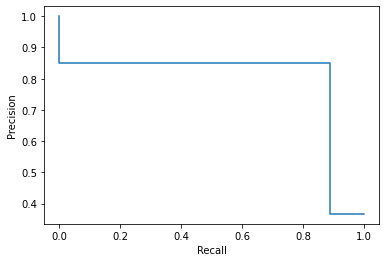

In [101]:
#PR curve
prec, recall, _ = precision_recall_curve(true_array, pred_array, #y_test(y_true),y_score:
                                         pos_label=None) 
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [102]:
aps=average_precision_score(true_array, pred_array, average='macro', pos_label=1, sample_weight=None)
print("Average precision score is:",aps)

Average precision score is: 0.7976728633488381


In [105]:
model3_f1 = f1_score(true_array, pred_array)
model3_precision = precision_score(true_array, pred_array) 
model3_recall = recall_score(true_array, pred_array) 
model3_auc = roc_auc_score(true_array, pred_array)
print('Test F1 score for Model 3:', model3_f1, '\nTest precision for Model 3:', model3_precision, 
      '\nTest recall for Model 3:', model3_recall,'\nTest auc for Model 3:', model3_auc)

Test F1 score for Model 3: 0.8700851603551368 
Test precision for Model 3: 0.8507054048830768 
Test recall for Model 3: 0.890368472507838 
Test auc for Model 3: 0.8998931420367171
